# Képek közelítése a bemeneti vektorok terében

Ezen notebook kiegészítséként szolgál a dolgozat 5. fejezetéhez.

## Tartalomjegyzék
1. [Képek közelítése pixel-szinten](#Képek-közelítése-pixel-szinten)
2. [Képek keresése osztályozó segítségével](#Képek-keresése-osztályozó-segítségével)

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

2022-05-03 14:45:35.732107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 14:45:35.732146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
generator = keras.models.load_model('./datas/weights/msggan/afhq/msgGenerator.h5')

latent_dim = 100

2022-05-03 14:45:38.765079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 14:45:38.765120: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 14:45:38.765153: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-05-03 14:45:38.765394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


A GAN által betanult térről nem kapunk egzakt információkat, nincs tudomásunk arról, hogy a modell hogyan helyezte el a sokdimenziós térben a tanult ismereteit. Egy betanított modell esetén csupán annyit látunk, hogy különböző random bemeneti vektorokra különféle képeket kapunk a generátor kimenetén.
Két random zajvektor között ha interpolálunk, akkor minden egyes mintavételezett pontból ki tudunk generálni olyan képeket, amelyek a két kép közti átmenetet jelentik és amelyeken megfigyelhetőek a két kép együttes tulajdonságai. Az alábbi ábrán látható példa az interpolációra.

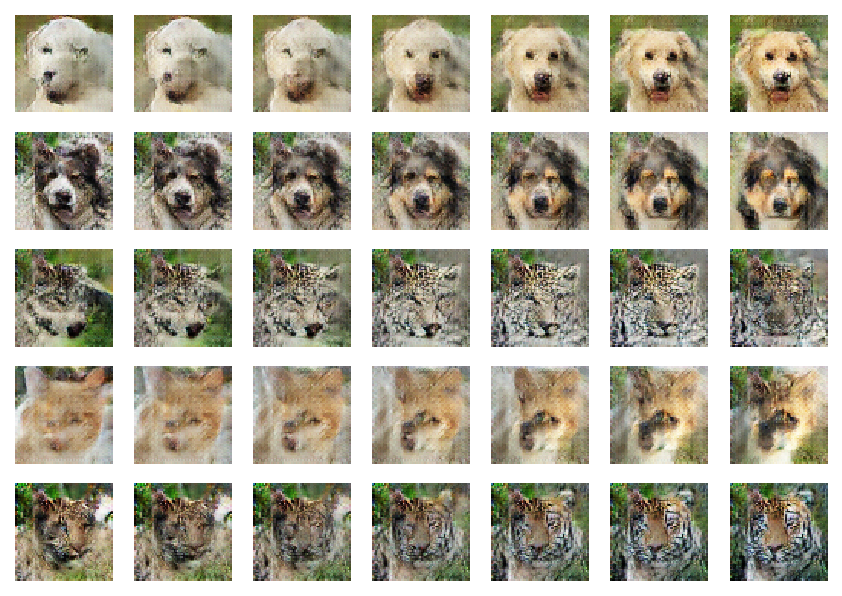

In [3]:
from scipy.interpolate import interp1d
import numpy as np

rows = 5
step_size = 8
fig, axes = plt.subplots(figsize=(step_size-1, rows), nrows=rows, ncols=step_size-1, dpi=150)

for k in range(rows):
    noises = tf.random.normal([2, latent_dim])
    res = []
    step_size = 8
    for i in range(1, len(noises)):
        linfit = interp1d([1, step_size], np.vstack([noises[i-1], noises[i]]), axis=0)
        for j in range(1,step_size):
            generated_image = generator(linfit(j).reshape(1,latent_dim), training=False)
            res.append(generated_image)
    for i in range(step_size-1):
        gen_1 = res[i][0][0].numpy()*127.5+127.5
        axes[k][i].axis('off')
        axes[k][i].imshow((gen_1).astype("uint32"), interpolation='none')
plt.show()

A képek közelítésre egy megoldás lehet a synthesis-through-optimization technika, amely-
hez nem kell betanítani egy újabb modellt, csupán optimalizációs alapon történik meg a képek
közelítése.

## Képek közelítése pixel-szinten

Két kép között a pixelszintű távolságot az L2 norma vagy euklideszi norma segítségével kaphatjuk meg. Ezen távolságot L2- vagy euklideszi távolságnak is lehet nevezni. A kép egyes pixeleinek értékeit veszi csupán figyelembe. Az összehasonlításhoz a képeket ki kell nyújtani, hogy egy-egy vektort kapjunk.

$$ \|x\|_2 = \left({\sum_{i=1}^{n}|x_i|^2}\right)^{\frac{1}{2}} $$

Egy kiválasztott kép közelítése a bemeneti vektorok terében az alábbi módon történhet:\\ 
Jelölje $X$ a keresendő képet, $G$ a generátort, $\vec{z} \in \mathbb{R}^{z_n}$ pedig a látens vektort.\\
A cél egy olyan $\vec{z} \in \mathbb{R}^{z_n}$ látens vektor keresése, amellyel az alábbi távolság minimalizálható.

$$ \min\left(\sum_{i=1}^{n\times m}\sqrt{(X_i-G(\vec{z})_i)^2}\right)$$

A képeket tehát pixelszinten hasonlítjuk össze kiindulásképp.
Egyéb metrikákat is alkalmazhatunk a képek hasonlóságának mérésére, viszont az optimalizáló módszer bemutatásához ezen legegyszerűbb módszert választottam.
Az optimalizálás a Gradiens módszer segítségével kerül megvalósításra.

In [4]:
def denormalize_image(image):
    return (image.numpy() * 127.5 + 127.5).astype("uint32")

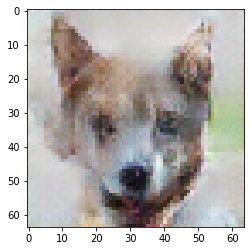

In [5]:
# this will be the goal image
starter_image_noise = tf.random.normal([1, latent_dim])
starter_image = generator(starter_image_noise, training=False)[0][0]
plt.imshow(denormalize_image(starter_image))

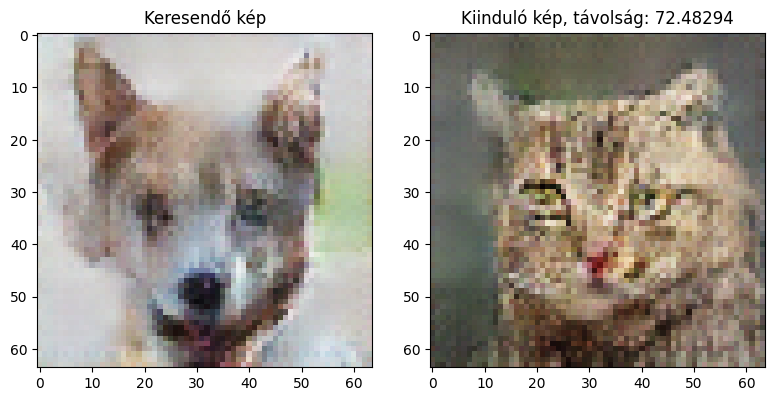

In [6]:
# generate a random starting point
random_noise = tf.random.uniform([1, latent_dim], minval=-1, maxval=1)

# generating an image from the random point
# and calculating the distance between the goal and the random image
random_image = generator(random_noise ,training=False)[0][0]

distance = tf.norm(starter_image-random_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(starter_image), interpolation='none')

axes[1].set_title("Kiinduló kép" + ", távolság: " + str(distance.numpy()))
axes[1].imshow(denormalize_image(random_image), interpolation='none')

In [7]:
# Gradient Descent

def gradient_descent(goal_image, starting_noise, step_size, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')
    losses = []
    for i in range(steps+1):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        gradients = g_tape.gradient(loss, noise)
        noise = noise - (step_size * gradients)

        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    generated_image = generator(noise, training=False)[0][0]
    return noise, losses

In [8]:
# Gradient Descent with Momentum

def gradient_descent_momentum(goal_image, starting_noise, step_size, momentum, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')

    losses = []
    result_noises = []
    
    change = 0
    for i in range(steps+1):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        result_noises.append(noise)
        
        gradients = g_tape.gradient(loss, noise)
        change = (step_size * gradients) + momentum * change
        noise = noise - change
        
        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    generated_image = generator(noise, training=False)[0][0]
    return result_noises, losses

2022-05-03 14:45:44.093790: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.
2022-05-03 14:45:44.118220: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.
2022-05-03 14:45:44.155666: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29360128 exceeds 10% of free system memory.
2022-05-03 14:45:44.168864: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19922944 exceeds 10% of free system memory.


Step: 0, Loss: 72.48294067382812


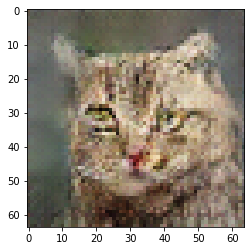

2022-05-03 14:45:44.463788: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.


Step: 1, Loss: 63.26511764526367


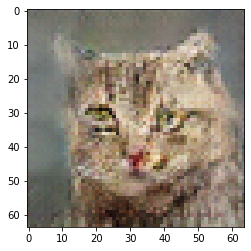

Step: 2, Loss: 54.09015655517578


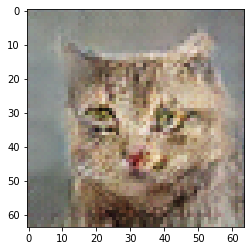

Step: 3, Loss: 45.1348876953125


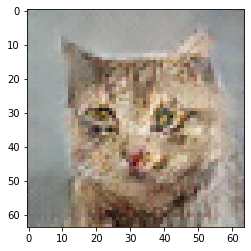

Step: 4, Loss: 37.91814041137695


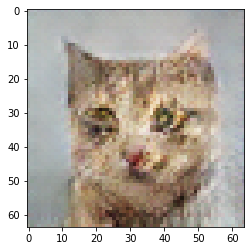

Step: 5, Loss: 35.09211349487305


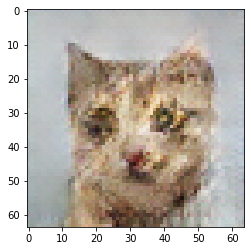

Step: 6, Loss: 33.75175857543945


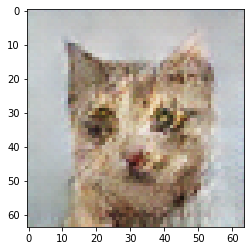

Step: 7, Loss: 32.70307540893555


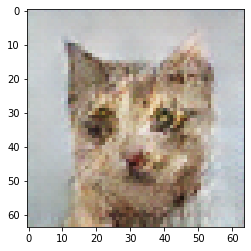

Step: 8, Loss: 31.787654876708984


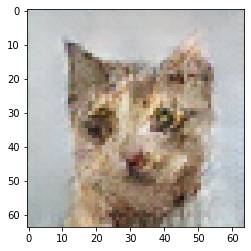

Step: 9, Loss: 31.175060272216797


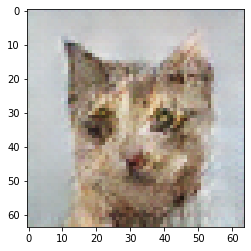

Step: 10, Loss: 30.71992301940918


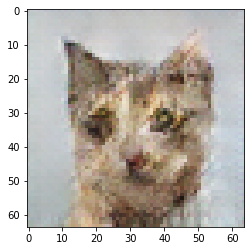

Step: 11, Loss: 30.362735748291016


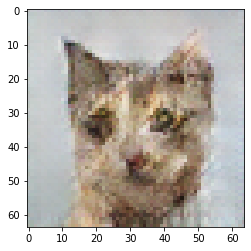

Step: 12, Loss: 30.026525497436523


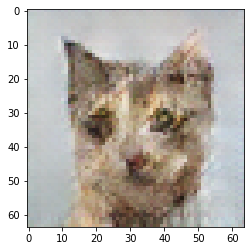

Step: 13, Loss: 29.70650863647461


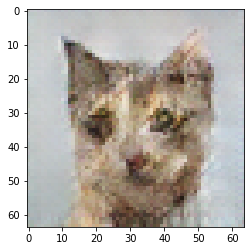

Step: 14, Loss: 29.34398078918457


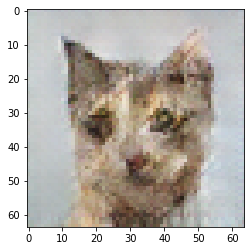

Step: 15, Loss: 29.007143020629883


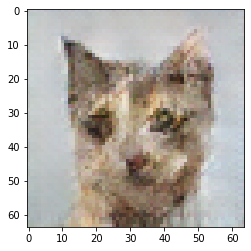

Step: 16, Loss: 28.71614646911621


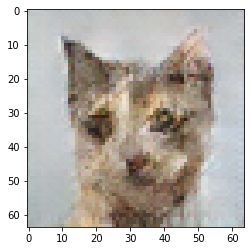

Step: 17, Loss: 28.42411994934082


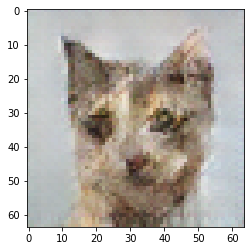

Step: 18, Loss: 28.135087966918945


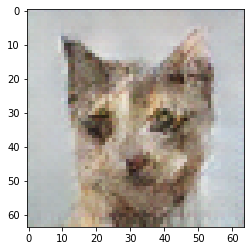

Step: 19, Loss: 27.863994598388672


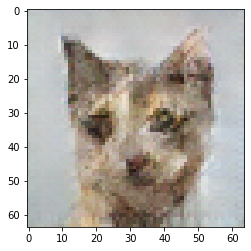

Step: 20, Loss: 27.596702575683594


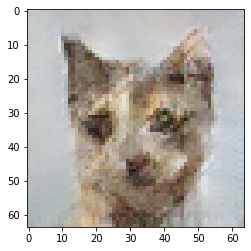

Step: 21, Loss: 27.296422958374023


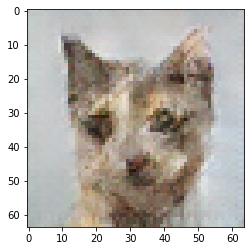

Step: 22, Loss: 26.986543655395508


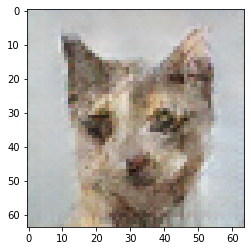

Step: 23, Loss: 26.648263931274414


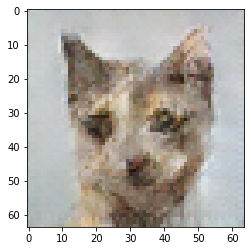

Step: 24, Loss: 26.31541633605957


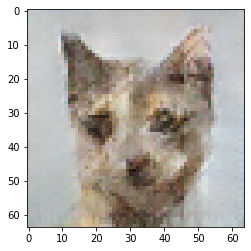

Step: 25, Loss: 26.003686904907227


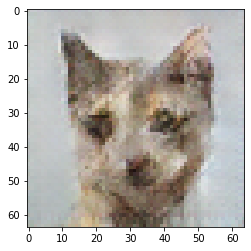

Step: 26, Loss: 25.702268600463867


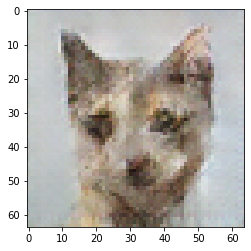

Step: 27, Loss: 25.42171859741211


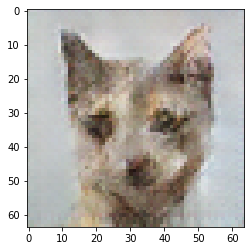

Step: 28, Loss: 25.140932083129883


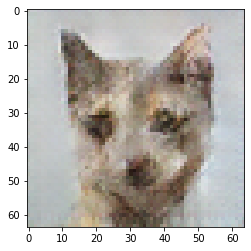

Step: 29, Loss: 24.84635353088379


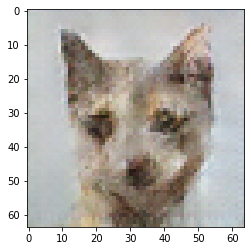

Step: 30, Loss: 24.562484741210938


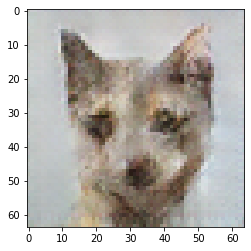

Step: 31, Loss: 24.307941436767578


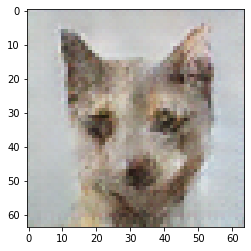

Step: 32, Loss: 24.06380844116211


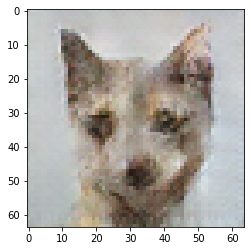

Step: 33, Loss: 23.820472717285156


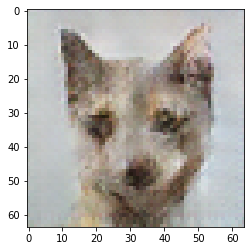

Step: 34, Loss: 23.598241806030273


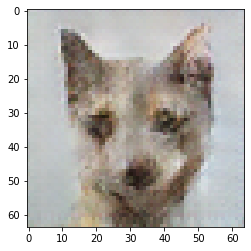

Step: 35, Loss: 23.385971069335938


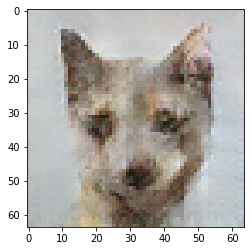

Step: 36, Loss: 23.18849754333496


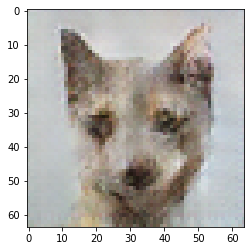

Step: 37, Loss: 22.996353149414062


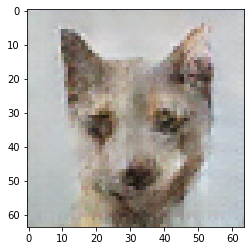

Step: 38, Loss: 22.828744888305664


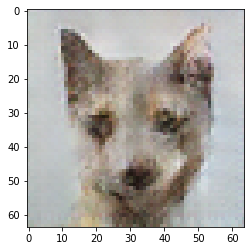

Step: 39, Loss: 22.67220115661621


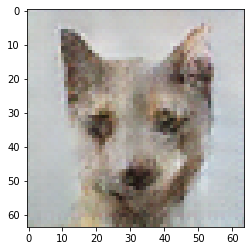

Step: 40, Loss: 22.51167869567871


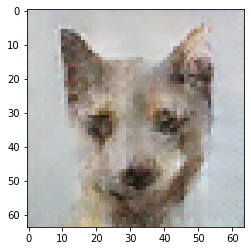

Step: 41, Loss: 22.353925704956055


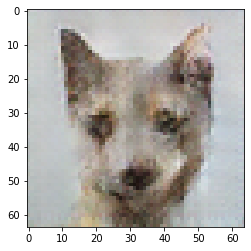

Step: 42, Loss: 22.203720092773438


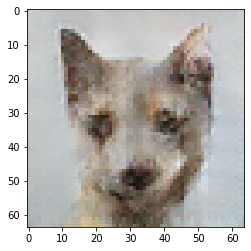

Step: 43, Loss: 22.053226470947266


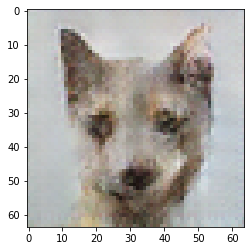

Step: 44, Loss: 21.892169952392578


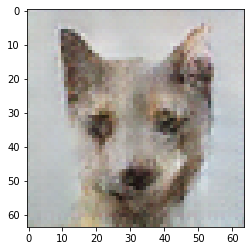

Step: 45, Loss: 21.740325927734375


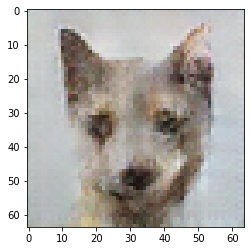

Step: 46, Loss: 21.598772048950195


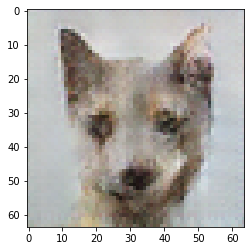

Step: 47, Loss: 21.46232032775879


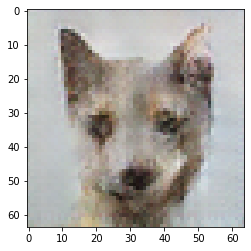

Step: 48, Loss: 21.329593658447266


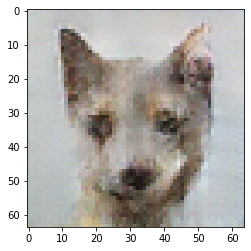

Step: 49, Loss: 21.172626495361328


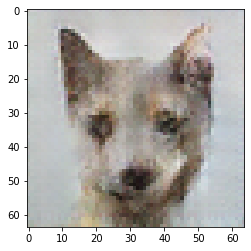

Step: 50, Loss: 21.006357192993164


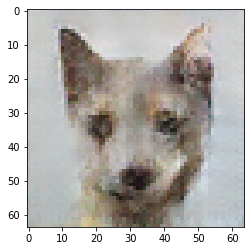

Step: 51, Loss: 20.83910369873047


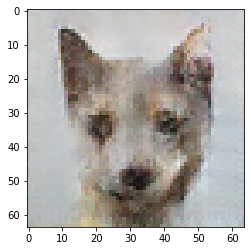

Step: 52, Loss: 20.62364387512207


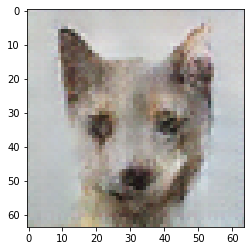

Step: 53, Loss: 20.43625831604004


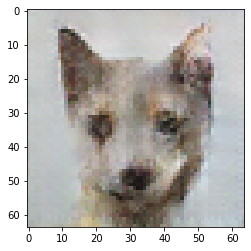

Step: 54, Loss: 20.257369995117188


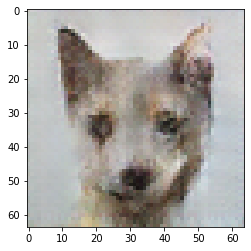

Step: 55, Loss: 20.081392288208008


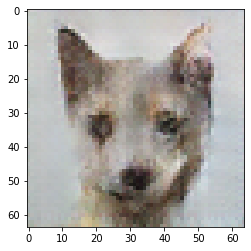

Step: 56, Loss: 19.892518997192383


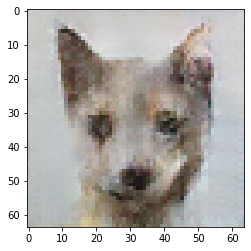

Step: 57, Loss: 19.658447265625


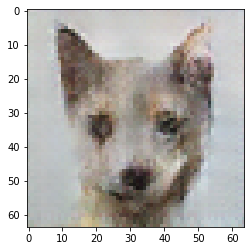

Step: 58, Loss: 19.415925979614258


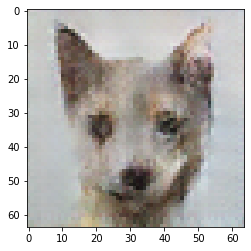

Step: 59, Loss: 19.160078048706055


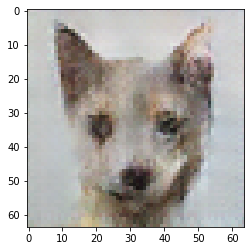

Step: 60, Loss: 18.94639778137207


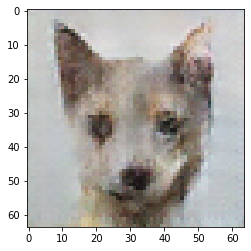

Step: 61, Loss: 18.745548248291016


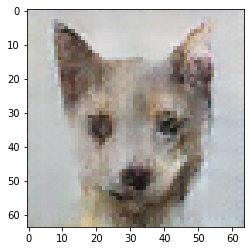

Step: 62, Loss: 18.55703353881836


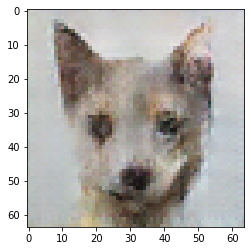

Step: 63, Loss: 18.385534286499023


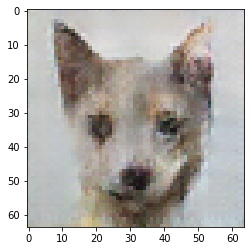

Step: 64, Loss: 18.230884552001953


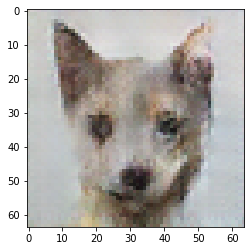

Step: 65, Loss: 18.09789276123047


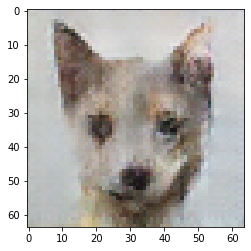

Step: 66, Loss: 17.989192962646484


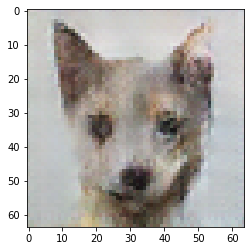

Step: 67, Loss: 17.851341247558594


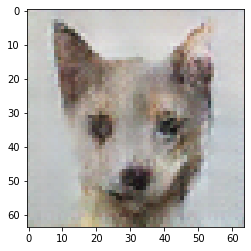

Step: 68, Loss: 17.782928466796875


Step: 69, Loss: 17.730754852294922


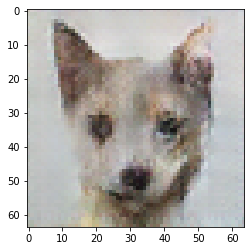

Step: 70, Loss: 17.697307586669922


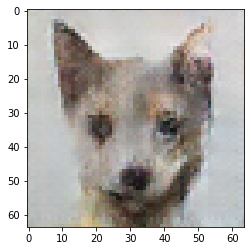

In [9]:
gradient_noise, gd_losses =\
    gradient_descent(
        starter_image, random_noise,
        step_size=0.02, steps=70, verbose=True
    )

Step: 0, Loss: 72.48294067382812


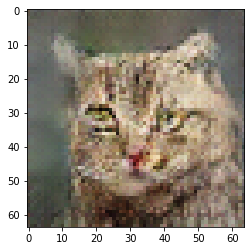

Step: 1, Loss: 63.26511764526367


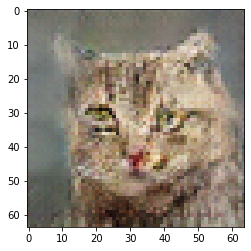

Step: 2, Loss: 46.40367126464844


Step: 3, Loss: 35.62345504760742


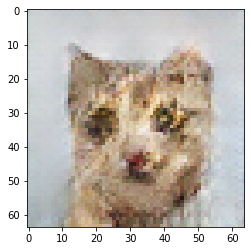

Step: 4, Loss: 42.066680908203125


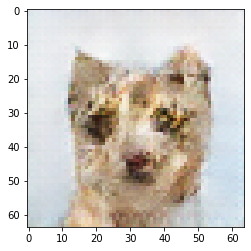

Step: 5, Loss: 44.510032653808594


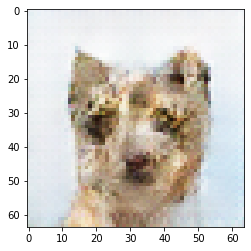

Step: 6, Loss: 43.30852508544922


Step: 7, Loss: 43.00345993041992


Step: 8, Loss: 42.970191955566406


Step: 9, Loss: 41.03108596801758


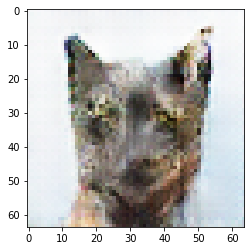

Step: 10, Loss: 37.384727478027344


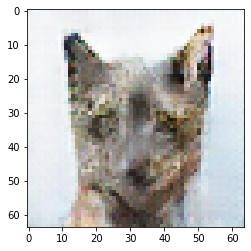

Step: 11, Loss: 35.23236083984375


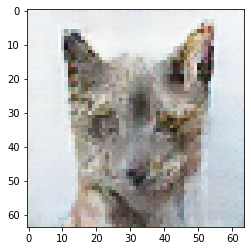

Step: 12, Loss: 33.94409942626953


Step: 13, Loss: 32.82517623901367


Step: 14, Loss: 31.445913314819336


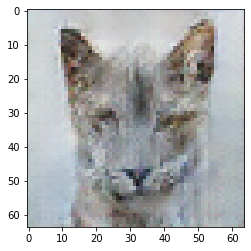

Step: 15, Loss: 30.43429183959961


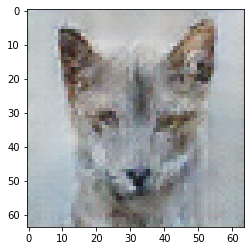

Step: 16, Loss: 30.022520065307617


Step: 17, Loss: 29.81598663330078


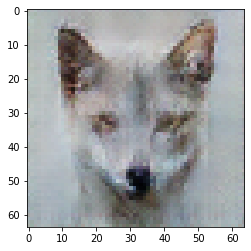

Step: 18, Loss: 28.78246307373047


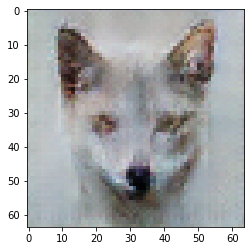

Step: 19, Loss: 26.802949905395508


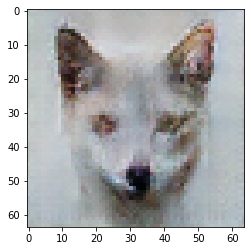

Step: 20, Loss: 24.514278411865234


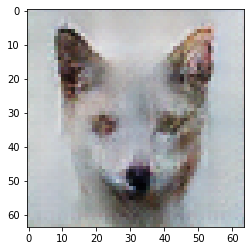

Step: 21, Loss: 23.282777786254883


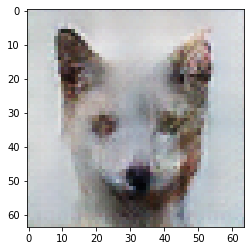

Step: 22, Loss: 24.100730895996094


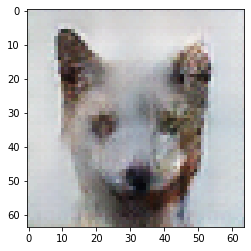

Step: 23, Loss: 24.336620330810547


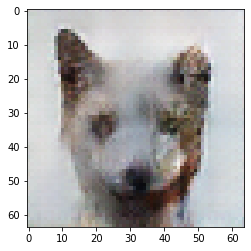

Step: 24, Loss: 22.715360641479492


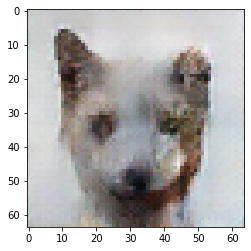

Step: 25, Loss: 20.58576202392578


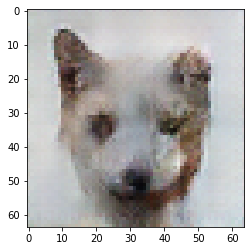

Step: 26, Loss: 19.863784790039062


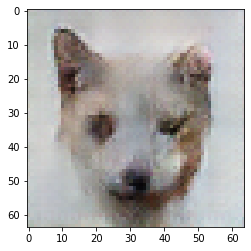

Step: 27, Loss: 20.409469604492188


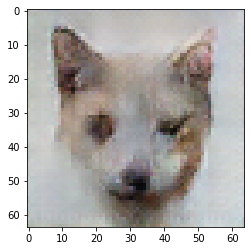

Step: 28, Loss: 20.703615188598633


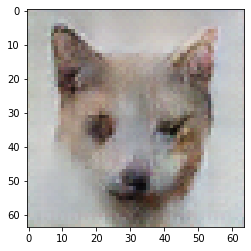

Step: 29, Loss: 19.875274658203125


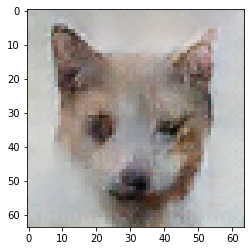

Step: 30, Loss: 18.990856170654297


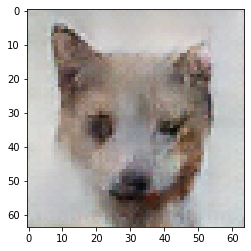

Step: 31, Loss: 18.810516357421875


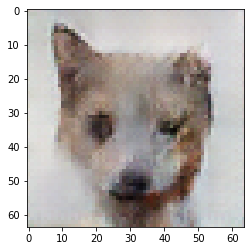

Step: 32, Loss: 19.11749839782715


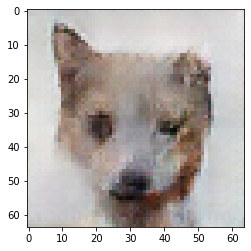

Step: 33, Loss: 19.03816795349121


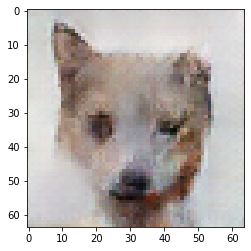

Step: 34, Loss: 18.163253784179688


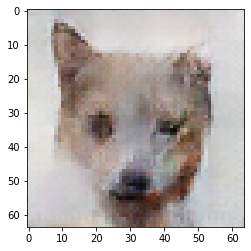

Step: 35, Loss: 17.19998550415039


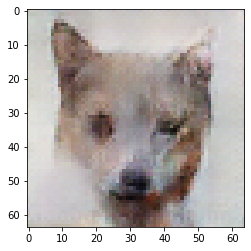

Step: 36, Loss: 17.40102767944336


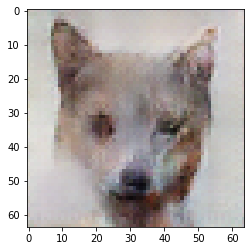

Step: 37, Loss: 17.346899032592773


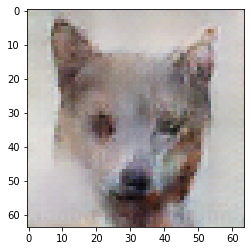

Step: 38, Loss: 16.350902557373047


Step: 39, Loss: 16.096168518066406


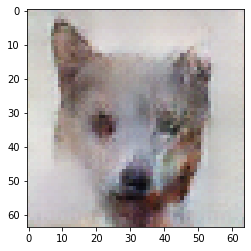

Step: 40, Loss: 16.238203048706055


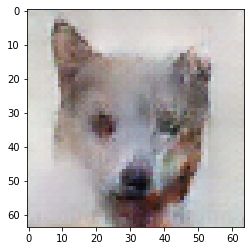

Step: 41, Loss: 15.66719913482666


Step: 42, Loss: 15.125716209411621


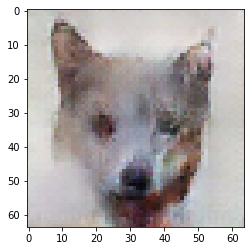

Step: 43, Loss: 15.152420043945312


Step: 44, Loss: 14.742159843444824


Step: 45, Loss: 14.41159725189209


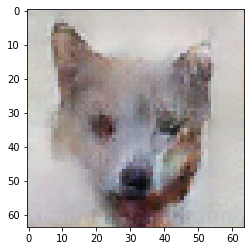

Step: 46, Loss: 14.165205001831055


Step: 47, Loss: 13.643954277038574


Step: 48, Loss: 13.619901657104492


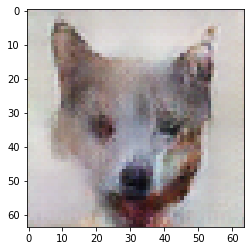

Step: 49, Loss: 13.117411613464355


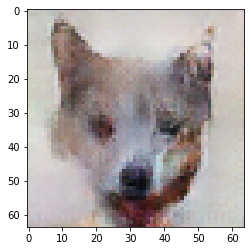

Step: 50, Loss: 12.71193790435791


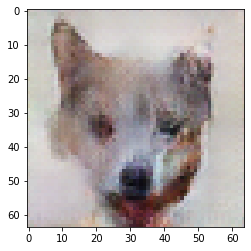

Step: 51, Loss: 12.603633880615234


Step: 52, Loss: 12.191996574401855


Step: 53, Loss: 12.015779495239258


Step: 54, Loss: 11.896184921264648


Step: 55, Loss: 11.595047950744629


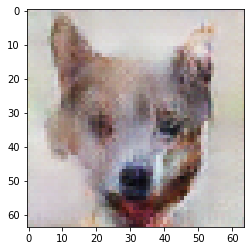

Step: 56, Loss: 11.387240409851074


Step: 57, Loss: 11.131881713867188


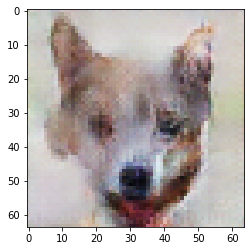

Step: 58, Loss: 10.858952522277832


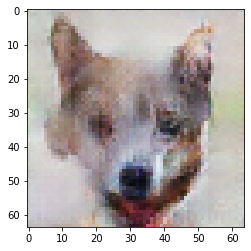

Step: 59, Loss: 10.58512020111084


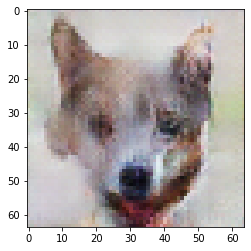

Step: 60, Loss: 10.289387702941895


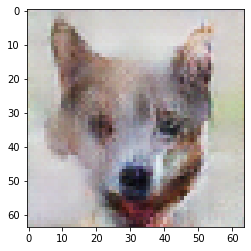

Step: 61, Loss: 10.184889793395996


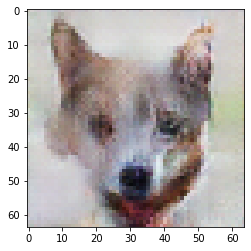

Step: 62, Loss: 9.924398422241211


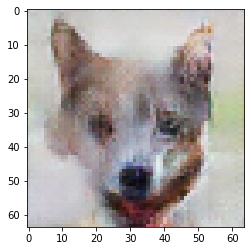

Step: 63, Loss: 9.880023002624512


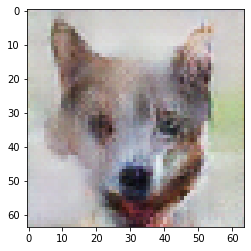

Step: 64, Loss: 9.673272132873535


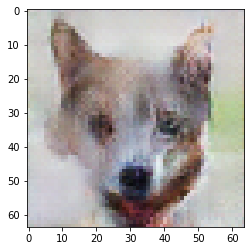

Step: 65, Loss: 9.625476837158203


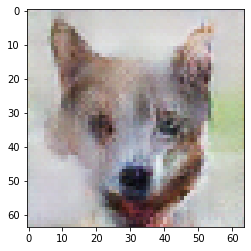

Step: 66, Loss: 9.475311279296875


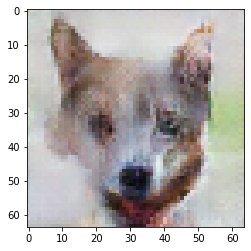

Step: 67, Loss: 9.444977760314941


Step: 68, Loss: 9.237339973449707


Step: 69, Loss: 9.1661958694458


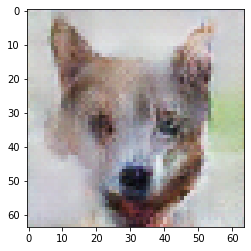

Step: 70, Loss: 9.010807037353516


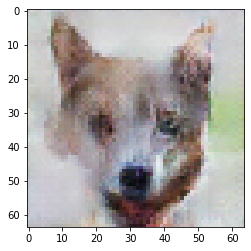

In [10]:
gradient_momentum_noises, gdm_losses =\
    gradient_descent_momentum(
        starter_image, random_noise,
        step_size=0.02, momentum=0.91,
        steps=70, verbose=True
    )

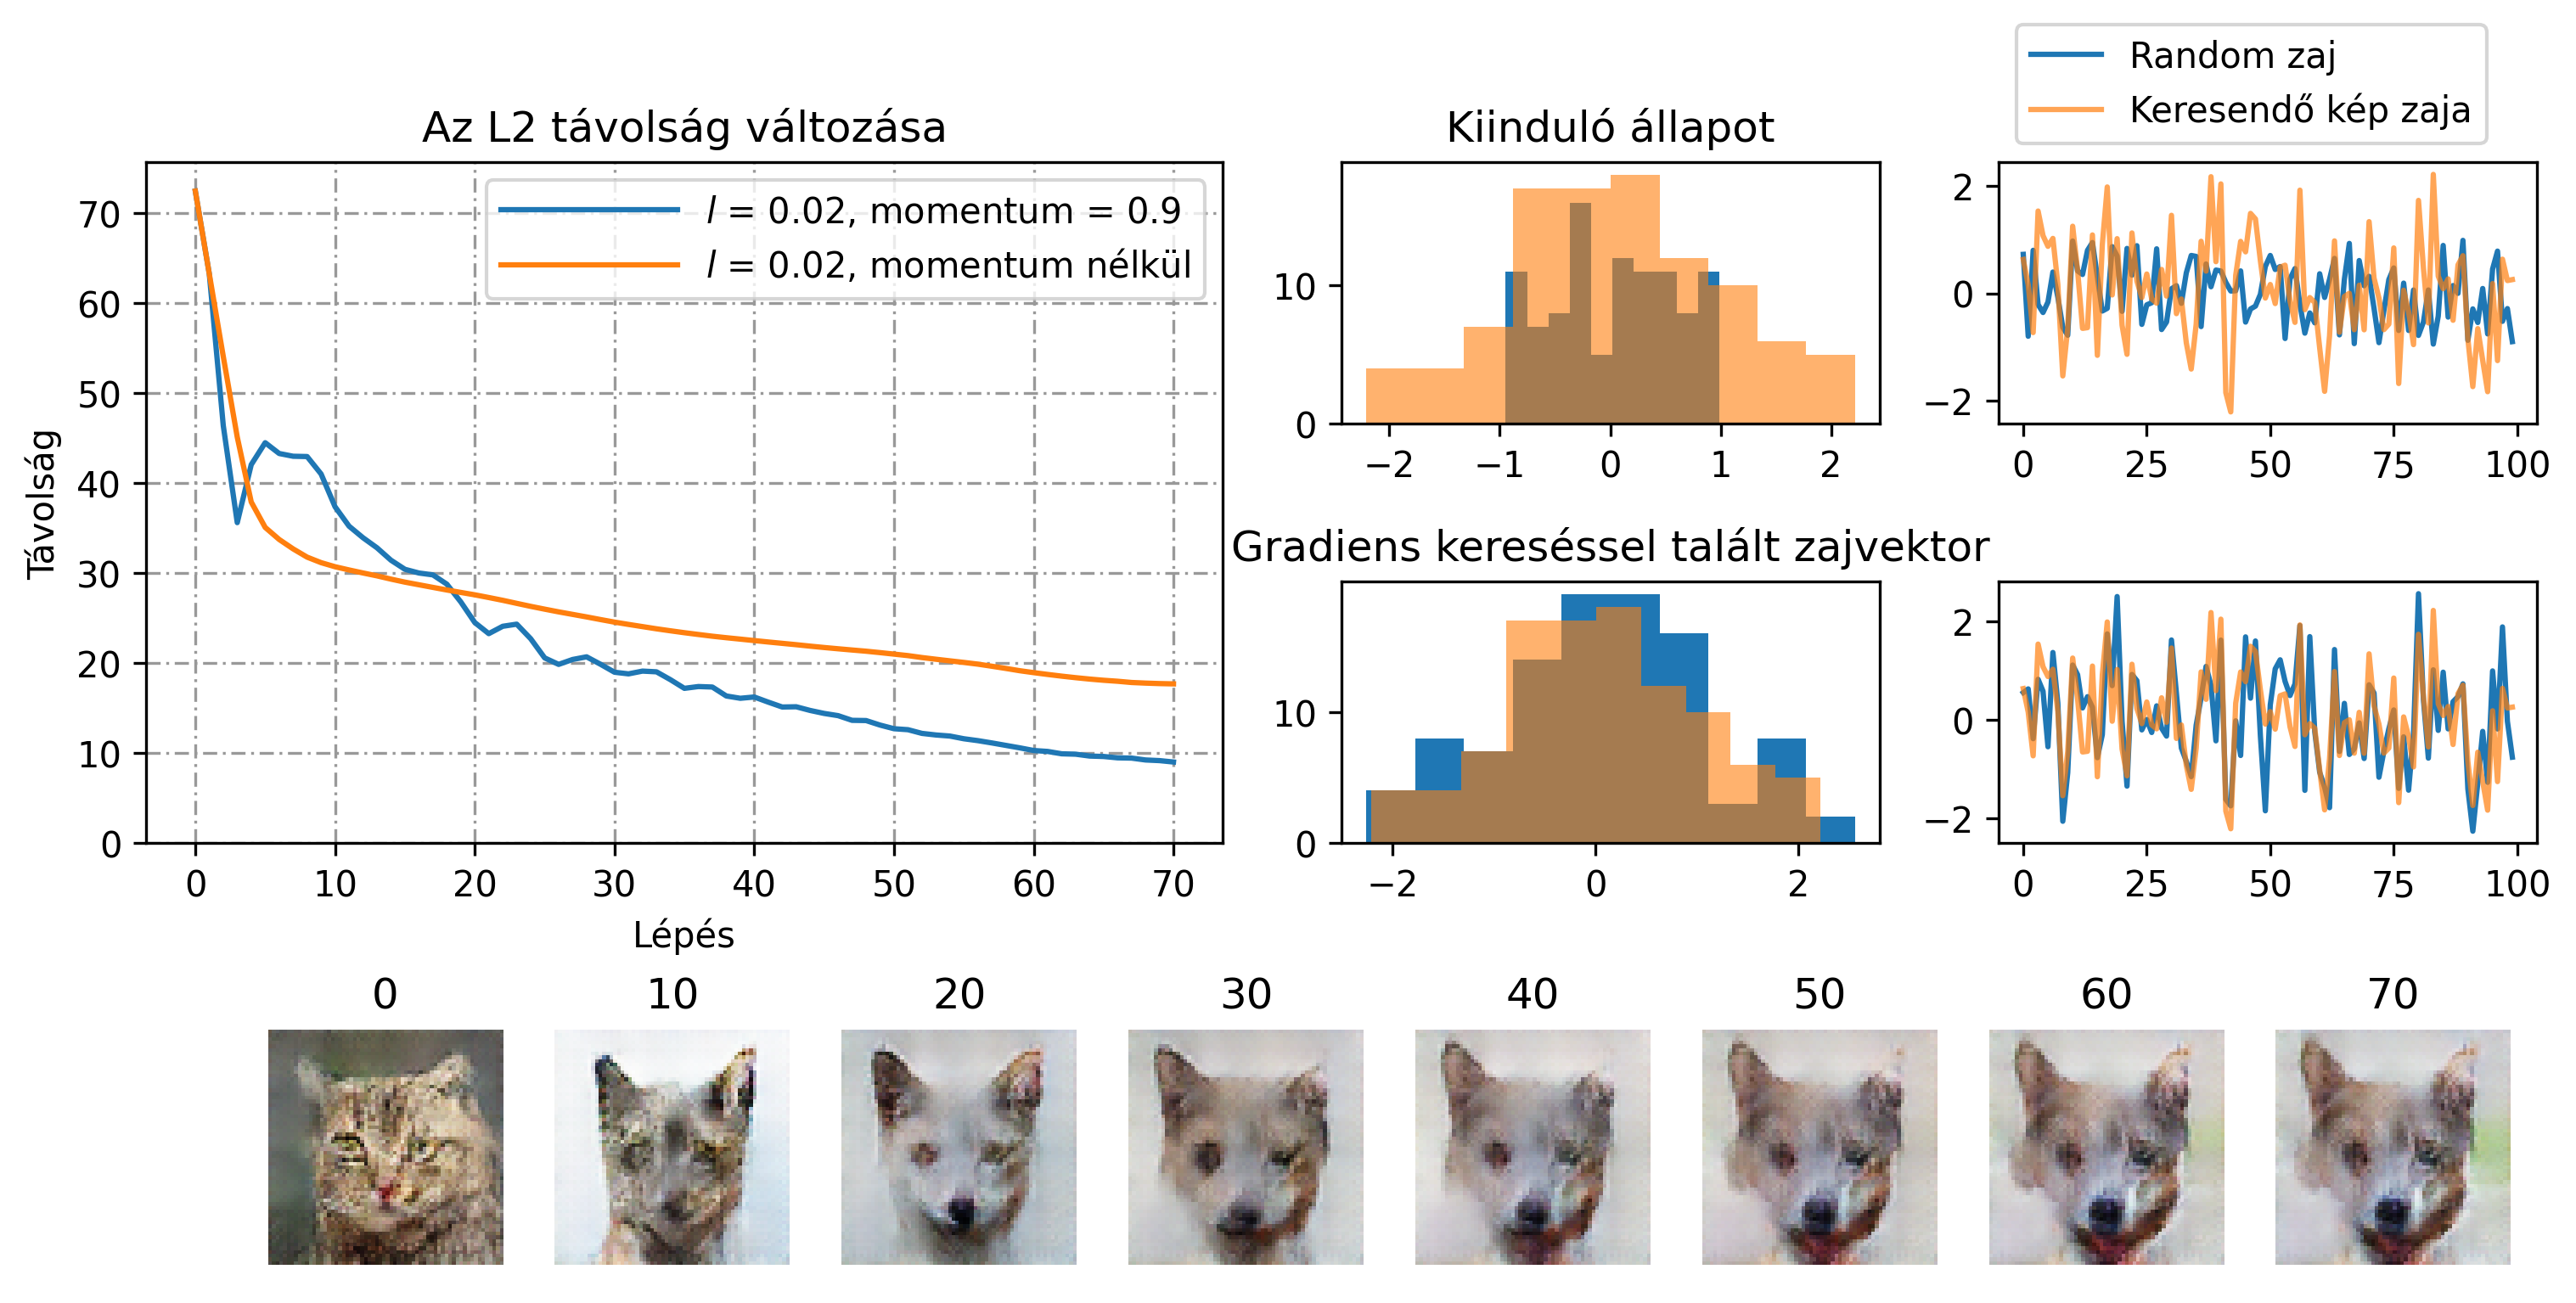

In [11]:
fig = plt.figure(figsize=(10, 5), dpi=300, constrained_layout=True)
axs = fig.subplot_mosaic([['Losses', 'TopRight', 'TopRight2'],['Losses', 'BottomRight', 'BottomRight2'], ['Images', 'Images', 'Images']],
                          gridspec_kw={'width_ratios':[2, 1, 1]})
axs['Losses'].set_xlabel('Lépés')
axs['Losses'].set_ylabel('Távolság')
axs['Losses'].set_title('Az L2 távolság változása')

axs['Losses'].grid(True, color='0.6', dashes=(5, 2, 1, 2))

axs['Losses'].plot(gdm_losses, label="$l$ = 0.02, momentum = 0.9")
axs['Losses'].plot(gd_losses, label="$l$ = 0.02, momentum nélkül")
axs['Losses'].set_ylim(bottom=0)
axs['Losses'].yaxis.set_major_locator(ticker.MultipleLocator(10))
axs['Losses'].xaxis.set_major_locator(ticker.MultipleLocator(10))
axs['Losses'].legend(loc=0, handlelength=5)

axs['TopRight'].set_title("Kiinduló állapot")
axs['TopRight'].hist(random_noise.numpy().flatten())
axs['TopRight'].hist(starter_image_noise.numpy().flatten(), alpha=0.6)

axs['TopRight2'].plot(random_noise.numpy().flatten(), label="Random zaj")
axs['TopRight2'].plot(starter_image_noise.numpy().flatten(), alpha=0.7, label="Keresendő kép zaja")
axs['TopRight2'].legend(loc='center left', bbox_to_anchor=(0.0, 1.3))

axs['BottomRight'].set_title("Gradiens kereséssel talált zajvektor")
axs['BottomRight'].hist(gradient_momentum_noises[-1].numpy().flatten())
axs['BottomRight'].hist(starter_image_noise.numpy().flatten(), alpha=0.6)

axs['BottomRight2'].plot(gradient_momentum_noises[-1].numpy().flatten())
axs['BottomRight2'].plot(starter_image_noise.numpy().flatten(), alpha=0.7)

inserted = []
axs['Images'].axis('off')
pad = 0.02
for i in range(8):
    inserted.append(axs['Images'].inset_axes([(i/10) + pad*i, 0.05, 0.2, 0.9]))

step = 10
for i in range(8):
    generated_image = generator(gradient_momentum_noises[i*step], training=False)[0]
    inserted[i].axis('off')
    inserted[i].set_title(i*step)
    inserted[i].imshow((generated_image[0].numpy()*127.5+127.5).astype("uint8"), interpolation="none")
plt.show()

In [12]:
grad_image = generator(gradient_noise, training=False)[0][0]

grad_momentum_image = generator(gradient_momentum_noises[-1], training=False)[0][0]

distance_grad = tf.norm(starter_image - grad_image)
distance_grad_momentum = tf.norm(starter_image - grad_momentum_image)

fig, axes = plt.subplots(figsize=(5, 5), nrows=2, ncols=2, dpi=100)
plt.tight_layout()
axes[0, 0].set_title("Keresendő kép")
axes[0, 0].imshow(denormalize_image(starter_image), interpolation='none')

axes[0, 1].set_title("Kiinduló kép" + ", távolság: " + '{0:.2f}'.format(distance.numpy()))
axes[0, 1].imshow(denormalize_image(random_image), interpolation='none')

axes[1, 0].set_title("grad" + ", távolság: " + '{0:.2f}'.format(distance_grad.numpy()))
axes[1, 0].imshow(denormalize_image(grad_image), interpolation='none')

axes[1, 1].set_title("grad + m" + ", távolság: " + '{0:.2f}'.format(distance_grad_momentum.numpy()))
axes[1, 1].imshow(denormalize_image(grad_momentum_image), interpolation='none')

In [13]:
validating_image = plt.imread("./datas/afhq/val/dog/flickr_dog_000212.jpg")

# Resize it to 64x64
resized = tf.image.resize(validating_image, [64, 64])

resized = (resized - 127.5) / 127.5  # Normalize image

plt.imshow(denormalize_image(resized))

Step: 0, Loss: 55.58946990966797


Step: 1, Loss: 54.52047348022461


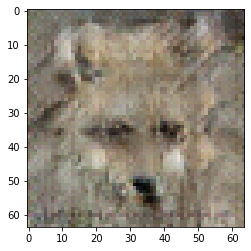

Step: 2, Loss: 52.67994689941406


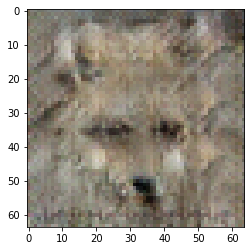

Step: 3, Loss: 50.744972229003906


Step: 4, Loss: 49.18118667602539


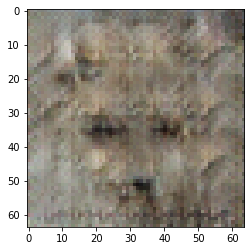

Step: 5, Loss: 48.16749954223633


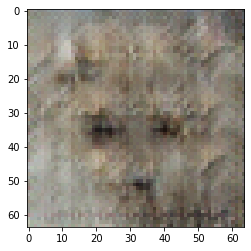

Step: 6, Loss: 47.970619201660156


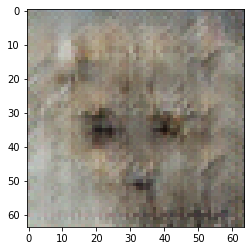

Step: 7, Loss: 47.85302734375


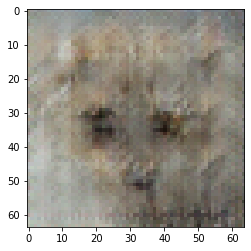

Step: 8, Loss: 47.152584075927734


Step: 9, Loss: 46.29869842529297


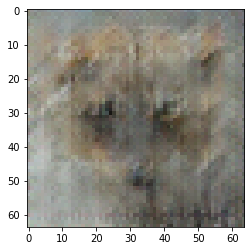

Step: 10, Loss: 45.984256744384766


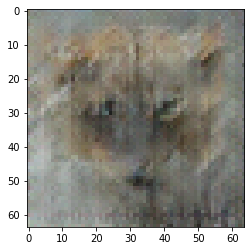

Step: 11, Loss: 45.562721252441406


Step: 12, Loss: 44.755123138427734


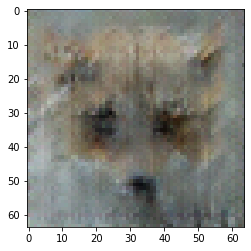

Step: 13, Loss: 44.252586364746094


Step: 14, Loss: 44.14122772216797


Step: 15, Loss: 44.27880096435547


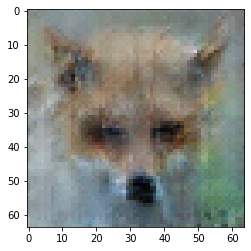

Step: 16, Loss: 44.03409194946289


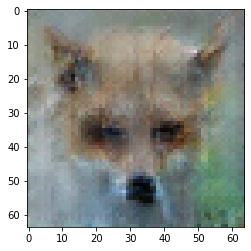

Step: 17, Loss: 43.510955810546875


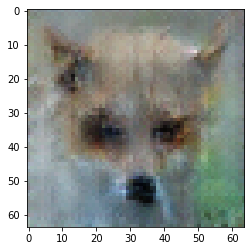

Step: 18, Loss: 43.062217712402344


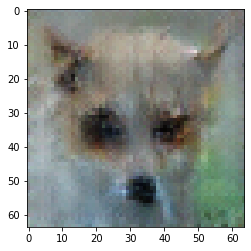

Step: 19, Loss: 42.80146026611328


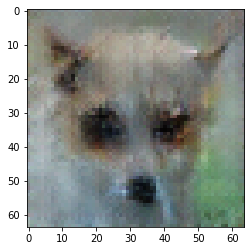

Step: 20, Loss: 42.581077575683594


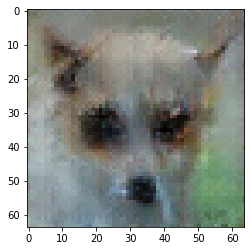

Step: 21, Loss: 42.3813591003418


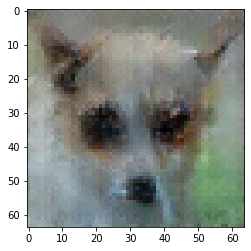

Step: 22, Loss: 42.23195266723633


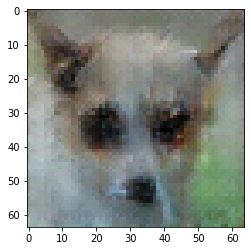

Step: 23, Loss: 42.02931594848633


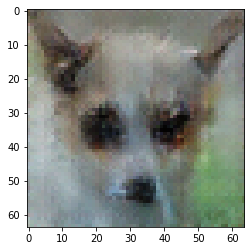

Step: 24, Loss: 41.756134033203125


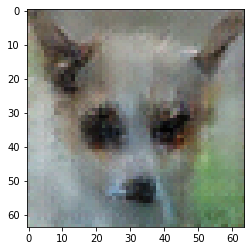

Step: 25, Loss: 41.46292495727539


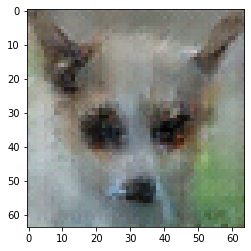

Step: 26, Loss: 41.2155876159668


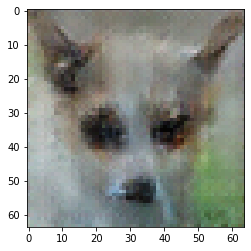

Step: 27, Loss: 40.988136291503906


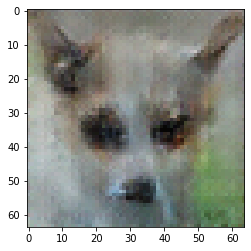

Step: 28, Loss: 40.7664680480957


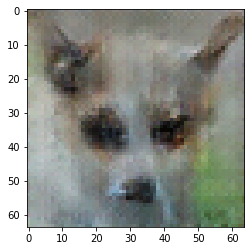

Step: 29, Loss: 40.60324478149414


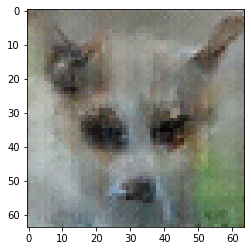

Step: 30, Loss: 40.43030548095703


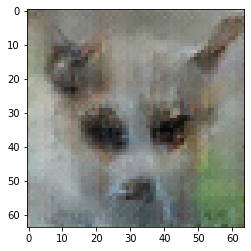

Step: 31, Loss: 40.3104248046875


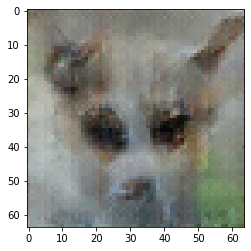

Step: 32, Loss: 40.18218994140625


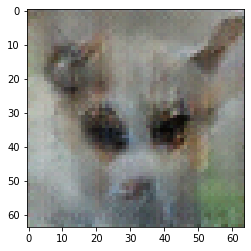

Step: 33, Loss: 40.013023376464844


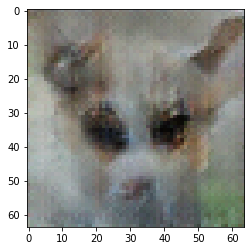

Step: 34, Loss: 39.789634704589844


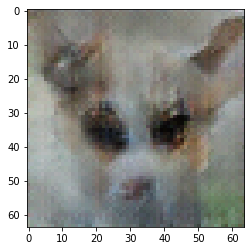

Step: 35, Loss: 39.5793571472168


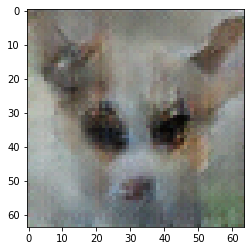

Step: 36, Loss: 39.3718376159668


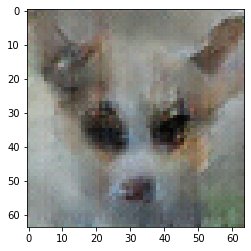

Step: 37, Loss: 39.20556640625


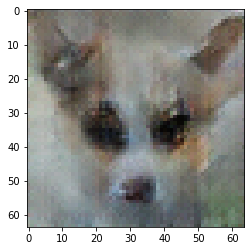

Step: 38, Loss: 39.054988861083984


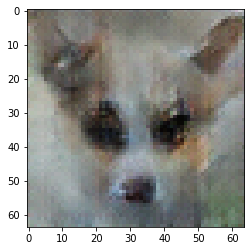

Step: 39, Loss: 38.9168586730957


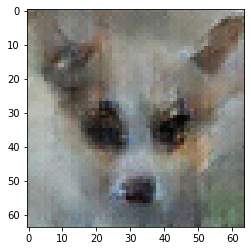

Step: 40, Loss: 38.73065948486328


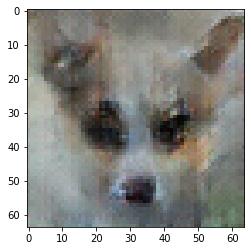

Step: 41, Loss: 38.57600021362305


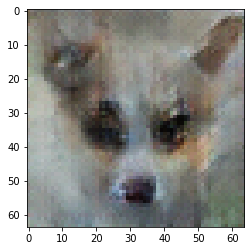

Step: 42, Loss: 38.41257858276367


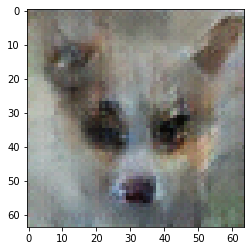

Step: 43, Loss: 38.271453857421875


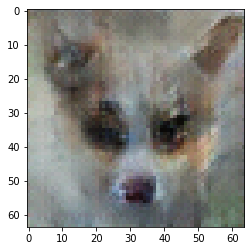

Step: 44, Loss: 38.18486404418945


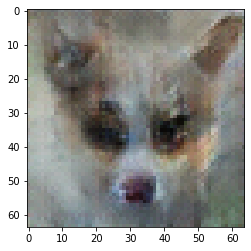

Step: 45, Loss: 38.11946105957031


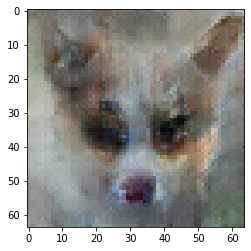

Step: 46, Loss: 38.00923538208008


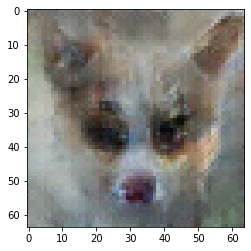

Step: 47, Loss: 37.86906051635742


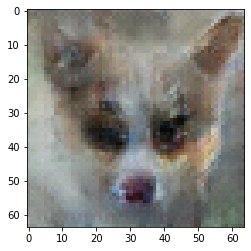

Step: 48, Loss: 37.75120544433594


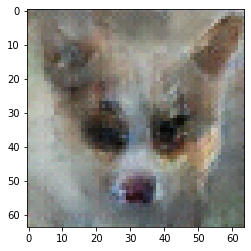

Step: 49, Loss: 37.65610885620117


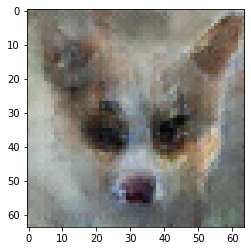

Step: 50, Loss: 37.612125396728516


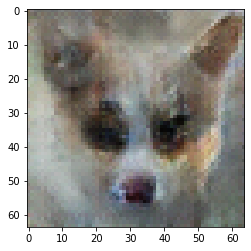

Step: 51, Loss: 37.555870056152344


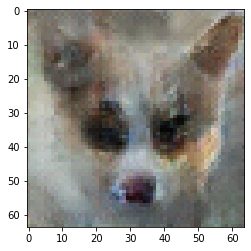

Step: 52, Loss: 37.44987106323242


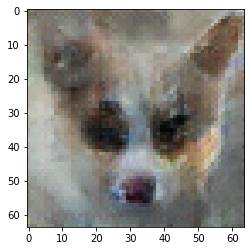

Step: 53, Loss: 37.34552764892578


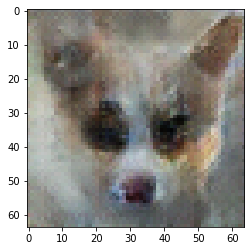

Step: 54, Loss: 37.260459899902344


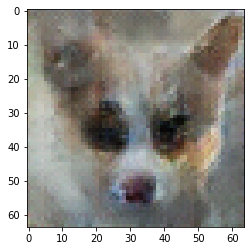

Step: 55, Loss: 37.18031311035156


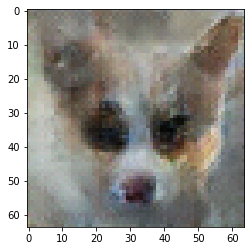

Step: 56, Loss: 37.08568572998047


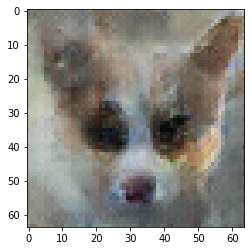

Step: 57, Loss: 37.00353240966797


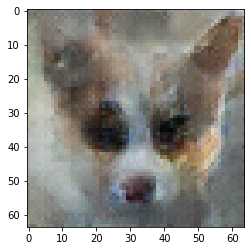

Step: 58, Loss: 36.914512634277344


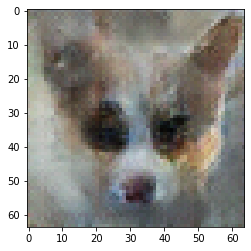

Step: 59, Loss: 36.816383361816406


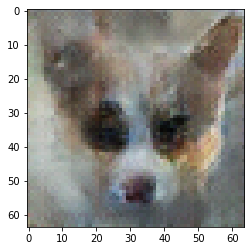

Step: 60, Loss: 36.73977279663086


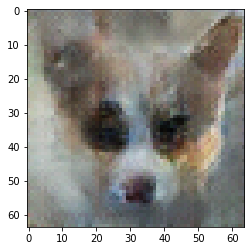

Step: 61, Loss: 36.68265151977539


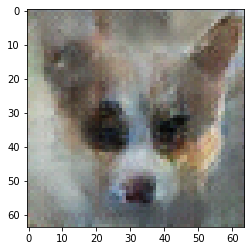

Step: 62, Loss: 36.62101745605469


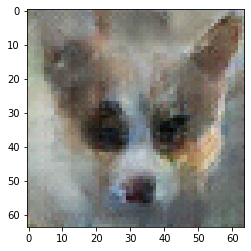

Step: 63, Loss: 36.54560852050781


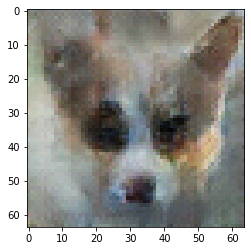

Step: 64, Loss: 36.484764099121094


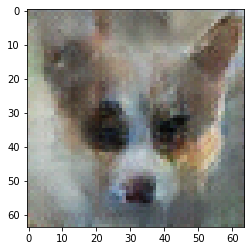

Step: 65, Loss: 36.424076080322266


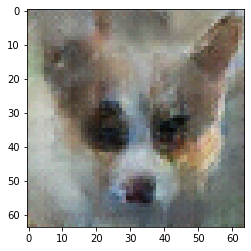

Step: 66, Loss: 36.3586311340332


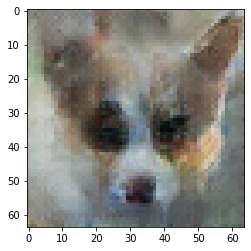

Step: 67, Loss: 36.30742263793945


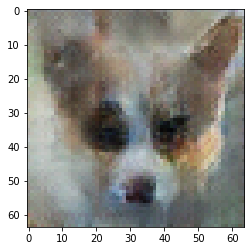

Step: 68, Loss: 36.27714920043945


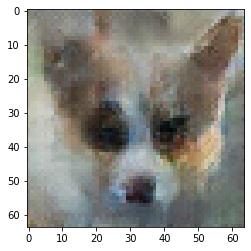

Step: 69, Loss: 36.2418212890625


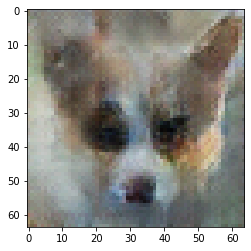

Step: 70, Loss: 36.20012283325195


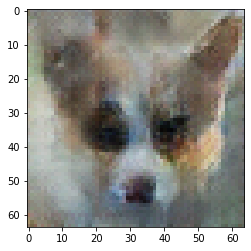

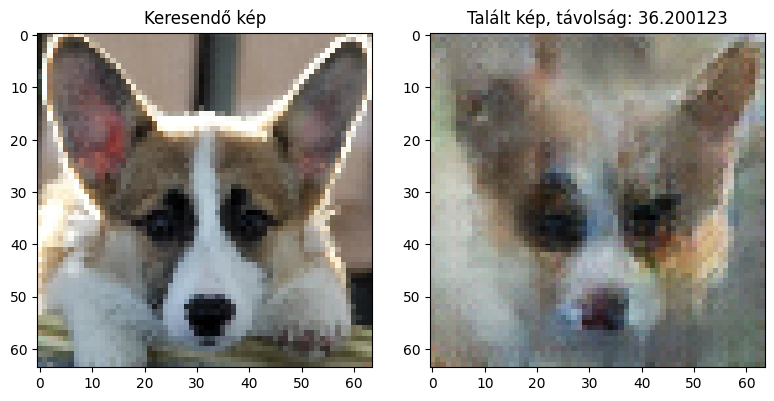

In [14]:
tf.random.set_seed(26)
noise = tf.random.uniform([1, latent_dim], minval=-1, maxval=1)

found_noise, _ = gradient_descent_momentum(resized, noise, step_size=0.03, momentum=0.9, steps=70, verbose=True)

found_image = generator(found_noise[-1], training=False)[0][0]

distance = tf.norm(resized - found_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(resized), interpolation='none')

axes[1].set_title("Talált kép" + ", távolság: " + str(distance.numpy()))
axes[1].imshow(denormalize_image(found_image), interpolation='none')

## Képek keresése osztályozó segítségével

A képek visszakeresése pixel szinten csupán azokban az esetekben adhat igazán jó megoldást,
amikor a Generátor egy korábbi kimenetére végezzük el a keresést. Az előbbiekben erre lát-
hattunk példát.
Ha a hibafüggvényt kicseréljük és az optimalizációt egy, az adathalmazon tanított osztályo-
zóval végezzük el, úgy viszonylag jó találatot kaphatunk. Természetesen ilyenkor az osztályozó
teljesítményétől is függ az eredmény jósága.

Megoldásként egy olyan osztályozó modellt állítottam össze, amelynek alapja az Inception modell.
A tanításhoz a Transfer-learning technikát alkalmaztam.

Az osztályozó tanításához szükséges notebook-ok:
- ./training_examples/classifier-Afhq.ipynb
- ./training_examples/classifier-Cifar10.ipynb
- ./training_examples/classifier-Cifar10(with_discriminator).ipynb

In [15]:
# Saját modell az inception v3 alapjaira (Transfer learning)
# (64, 64, 3)-as képeket vár bemenetként, majd one-hot encoding alapján adja ki a classokat (3 class)
# nem logits kimenetű
classifier = keras.models.load_model('datas/weights/classifier/animalFacesClassifier.h5')

In [16]:
# Gradient Descent with momentum
cross_entropy = keras.losses.CategoricalCrossentropy(from_logits=False)

def gradient_descent_momentum(goal_label, starting_noise, step_size, momentum, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')
    
    result_noises = []
    losses = []
    preds = []
    
    change = 0
    for i in range(steps):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0]
            predictions = classifier(generated_image)
            loss = cross_entropy(goal_label, predictions[0])
            
        result_noises.append(noise)
        preds.append(predictions[0])
        losses.append(loss)

        gradients = g_tape.gradient(loss, noise)
        change = (step_size * gradients) + momentum * change
        noise = noise - change

        if(verbose):
            print(predictions)
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow((generated_image[0].numpy()*127.5+127.5).astype("uint8"), interpolation="none")
            plt.show()

    return result_noises, losses, preds

In [17]:
def make_onehot_from_dict(input_data):
    return [input_data['cat'], input_data['dog'], input_data['wild']]

tf.Tensor([[0.15581712 0.08687016 0.7573127 ]], shape=(1, 3), dtype=float32)
Step: 0, Loss: 2.443340539932251


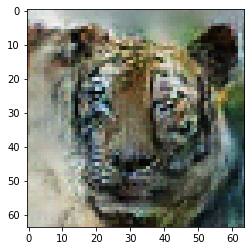

tf.Tensor([[8.4956962e-04 2.4169820e-04 9.9890876e-01]], shape=(1, 3), dtype=float32)
Step: 1, Loss: 8.327820777893066


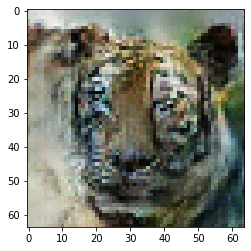

tf.Tensor([[0.04638919 0.13026212 0.82334876]], shape=(1, 3), dtype=float32)
Step: 2, Loss: 2.0382065773010254


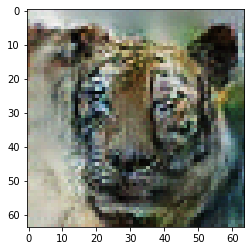

tf.Tensor([[0.39444774 0.19314805 0.41240418]], shape=(1, 3), dtype=float32)
Step: 3, Loss: 1.6442983150482178


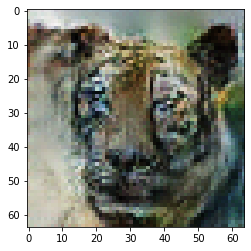

tf.Tensor([[0.20544855 0.38559482 0.40895665]], shape=(1, 3), dtype=float32)
Step: 4, Loss: 0.952968180179596


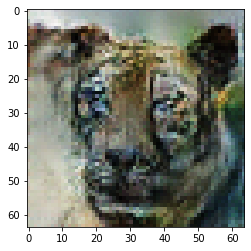

tf.Tensor([[0.5327698  0.13947207 0.3277581 ]], shape=(1, 3), dtype=float32)
Step: 5, Loss: 1.9698909521102905


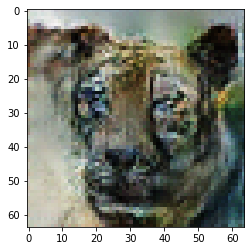

tf.Tensor([[0.22099902 0.12106773 0.65793324]], shape=(1, 3), dtype=float32)
Step: 6, Loss: 2.11140513420105


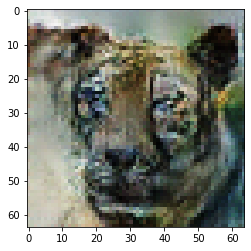

tf.Tensor([[0.00747991 0.07093554 0.92158455]], shape=(1, 3), dtype=float32)
Step: 7, Loss: 2.6459836959838867


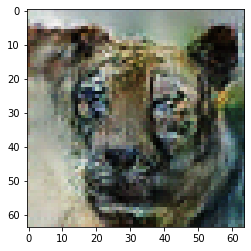

tf.Tensor([[0.7860548  0.02852763 0.18541749]], shape=(1, 3), dtype=float32)
Step: 8, Loss: 3.556881904602051


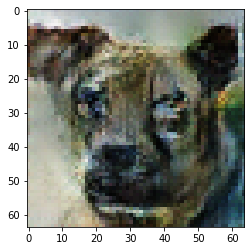

tf.Tensor([[0.09940187 0.8336919  0.0669062 ]], shape=(1, 3), dtype=float32)
Step: 9, Loss: 0.18189138174057007


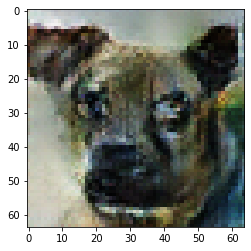

tf.Tensor([[0.85204464 0.14158873 0.00636663]], shape=(1, 3), dtype=float32)
Step: 10, Loss: 1.9548286199569702


tf.Tensor([[4.5411888e-04 9.9865687e-01 8.8895677e-04]], shape=(1, 3), dtype=float32)
Step: 11, Loss: 0.001343974145129323


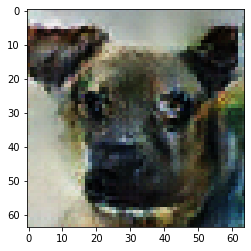

tf.Tensor([[0.30824393 0.67554224 0.01621374]], shape=(1, 3), dtype=float32)
Step: 12, Loss: 0.392239511013031


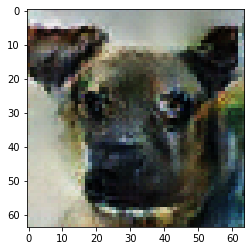

tf.Tensor([[0.52842045 0.41819012 0.05338939]], shape=(1, 3), dtype=float32)
Step: 13, Loss: 0.871819019317627


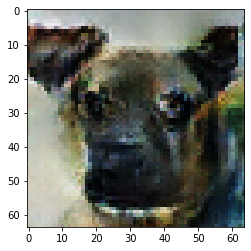

tf.Tensor([[5.0498955e-03 9.9421424e-01 7.3587499e-04]], shape=(1, 3), dtype=float32)
Step: 14, Loss: 0.005802565719932318


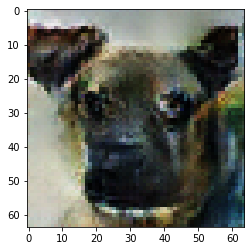

tf.Tensor([[0.0375656  0.95999694 0.00243751]], shape=(1, 3), dtype=float32)
Step: 15, Loss: 0.04082518443465233


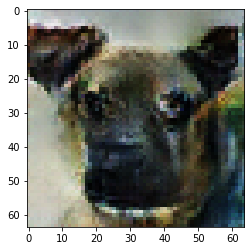

tf.Tensor([[2.2557311e-04 9.9905401e-01 7.2043098e-04]], shape=(1, 3), dtype=float32)
Step: 16, Loss: 0.000946433050557971


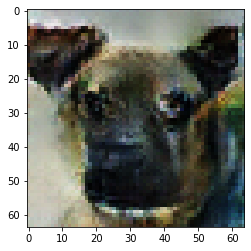

tf.Tensor([[0.00172873 0.99652964 0.0017417 ]], shape=(1, 3), dtype=float32)
Step: 17, Loss: 0.0034763969015330076


tf.Tensor([[6.559599e-02 9.338939e-01 5.100747e-04]], shape=(1, 3), dtype=float32)
Step: 18, Loss: 0.06839242577552795


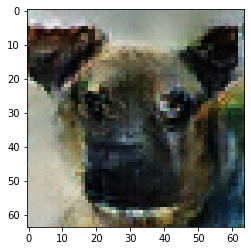

tf.Tensor([[0.02198327 0.97422767 0.00378911]], shape=(1, 3), dtype=float32)
Step: 19, Loss: 0.02611025795340538


tf.Tensor([[0.00335336 0.99314827 0.00349842]], shape=(1, 3), dtype=float32)
Step: 20, Loss: 0.006875313818454742


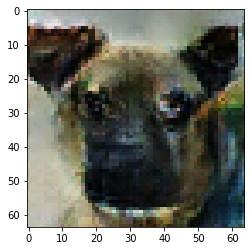

tf.Tensor(0.006875314, shape=(), dtype=float32)


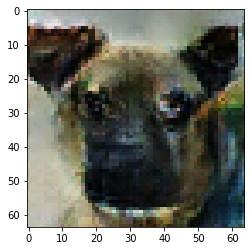

In [18]:
input_data = {
    "cat": 0.0,
    "dog": 1.0,
    "wild": 0.0
}

goal_prediction = make_onehot_from_dict(input_data)
starting_noise = tf.random.normal([1, latent_dim])

step_size = 0.005
momentum = 0.9

n_steps = 21

result_noises, losses, preds =\
    gradient_descent_momentum(goal_prediction, starting_noise, step_size, momentum, n_steps, verbose=True)

print(losses[-1])
generated_image = generator(result_noises[-1], training=False)[0]
plt.imshow((generated_image[0].numpy()*127.5+127.5).astype("uint8"), interpolation="none")
plt.show()

In [19]:
def plot_convergence(result_noises, losses, preds,
                     image_step, dpi=100):
    fig = plt.figure(figsize=(8, 4), dpi=dpi, constrained_layout=True)
    axs = fig.subplot_mosaic([['Losses', 'Classes'],['Images', 'Images']],
                            gridspec_kw={
                                'width_ratios':[2, 2],
                                'height_ratios':[2, 1]
                            })
    axs['Losses'].set_xlabel('Lépés')
    axs['Losses'].set_ylabel('Távolság')
    axs['Losses'].set_title('A loss változása az iterációkban')
    axs['Losses'].grid(True, color='0.6', dashes=(5, 2, 1, 2))
    axs['Losses'].plot(losses)
    axs['Losses'].set_ylim(bottom=0)

    axs['Classes'].set_ylabel('Valószínűség')
    axs['Classes'].set_xlabel('Lépés')
    axs['Classes'].set_title('Címkék valószínűségi értéke')

    axs['Classes'].grid(True, color='0.6', dashes=(5, 2, 1, 2))
    axs['Classes'].plot(preds, label=["cat", "dog", "wild"])

    axs['Classes'].set_ylim(bottom=0)
    axs['Classes'].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    inserted = []
    axs['Images'].axis('off')
    pad = 0.1
    for i in range(5):
        inserted.append(
            axs['Images'].inset_axes([(i/10) + pad*i, 0.05, 0.2, 0.9])
        )

    for i in range(5):
        generated_image = generator(result_noises[i*image_step],
                                         training=False)[0]
        inserted[i].axis('off')
        inserted[i].set_title(i*image_step)
        inserted[i].imshow(
            (generated_image[0].numpy()*127.5+127.5).astype("uint8"),
            interpolation="none"
        )
    plt.show()

In [20]:
plot_convergence(result_noises, losses, preds, image_step=5)

In [21]:
# Egy kutya és egy macska keresése, majd interpoláció a kettő között:

dog_label = [0, 1, 0]
cat_label = [1, 0, 0]

starting_noise = tf.random.truncated_normal([1, latent_dim])
dog_noise, _, _ =\
        gradient_descent_momentum(dog_label, starting_noise, 0.005, 0.9, 20, verbose=False)

starting_noise = tf.random.truncated_normal([1, latent_dim])
cat_noise, _, _ =\
        gradient_descent_momentum(cat_label, starting_noise, 0.005, 0.9, 20, verbose=False)

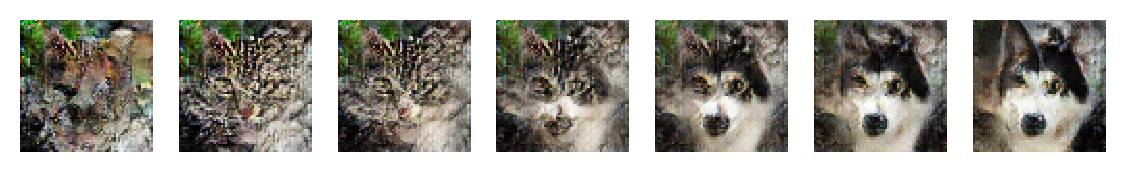

In [22]:
step_size = 8
linfit = interp1d([1, step_size], np.vstack([dog_noise[-1], cat_noise[-1]]), axis=0)

res = []
for j in range(1,step_size):
    generated_image = generator(linfit(j).reshape(1, latent_dim), training=False)[0]
    res.append(generated_image)
        
fig, axes = plt.subplots(figsize=(len(res), 1), nrows=1, ncols=len(res), dpi=200)
for i in range(len(res)):
    gen_1 = res[i][0].numpy()*127.5+127.5
    axes[i].axis('off')
    axes[i].imshow((gen_1).astype("uint8"), interpolation='none')
plt.show()

tf.Tensor([[0.09695268 0.8306209  0.07242642]], shape=(1, 3), dtype=float32)
Step: 0, Loss: 2.391862630844116


tf.Tensor([[0.22579518 0.17430636 0.59989846]], shape=(1, 3), dtype=float32)
Step: 1, Loss: 1.2927005290985107


tf.Tensor([[0.08190791 0.84237313 0.07571892]], shape=(1, 3), dtype=float32)
Step: 2, Loss: 2.5178732872009277


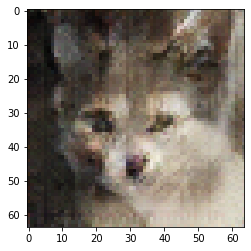

tf.Tensor([[0.19905607 0.75594115 0.04500277]], shape=(1, 3), dtype=float32)
Step: 3, Loss: 1.911541223526001


tf.Tensor([[0.2186866  0.7642378  0.01707559]], shape=(1, 3), dtype=float32)
Step: 4, Loss: 2.030113458633423


tf.Tensor([[0.15488888 0.7812685  0.06384261]], shape=(1, 3), dtype=float32)
Step: 5, Loss: 2.042304754257202


tf.Tensor([[9.9599528e-01 3.6332360e-03 3.7147355e-04]], shape=(1, 3), dtype=float32)
Step: 6, Loss: 1.58281672000885


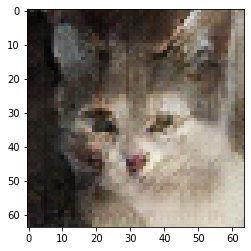

tf.Tensor([[9.974866e-01 1.900764e-03 6.126663e-04]], shape=(1, 3), dtype=float32)
Step: 7, Loss: 1.4815512895584106


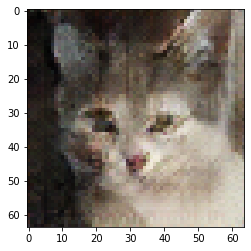

tf.Tensor([[9.9995375e-01 1.0547116e-05 3.5812875e-05]], shape=(1, 3), dtype=float32)
Step: 8, Loss: 2.047477960586548


tf.Tensor([[0.9779087  0.01567372 0.00641762]], shape=(1, 3), dtype=float32)
Step: 9, Loss: 1.0276128053665161


tf.Tensor([[9.9575704e-01 3.4789969e-03 7.6401560e-04]], shape=(1, 3), dtype=float32)
Step: 10, Loss: 1.4387861490249634


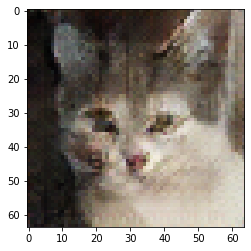

tf.Tensor([[0.7650098  0.21650025 0.01848995]], shape=(1, 3), dtype=float32)
Step: 11, Loss: 1.0123989582061768


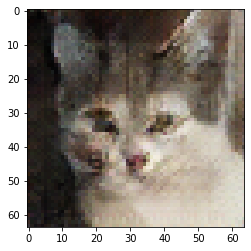

tf.Tensor([[0.7836692  0.19799578 0.018335  ]], shape=(1, 3), dtype=float32)
Step: 12, Loss: 0.9948033094406128


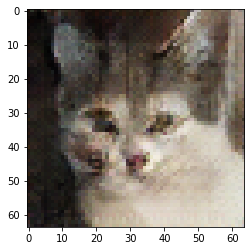

tf.Tensor([[0.9617154  0.03009047 0.00819399]], shape=(1, 3), dtype=float32)
Step: 13, Loss: 0.992099940776825


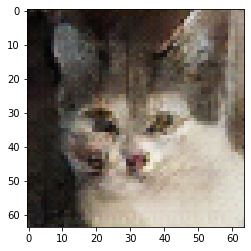

tf.Tensor([[0.26852858 0.4145096  0.31696177]], shape=(1, 3), dtype=float32)
Step: 14, Loss: 1.2816331386566162


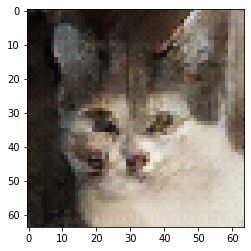

tf.Tensor([[0.10497541 0.70068794 0.19433667]], shape=(1, 3), dtype=float32)
Step: 15, Loss: 2.1308557987213135


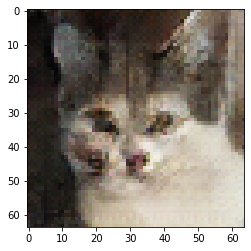

tf.Tensor([[0.9966175  0.00226385 0.00111866]], shape=(1, 3), dtype=float32)
Step: 16, Loss: 1.3618347644805908


tf.Tensor([[0.987412   0.00910924 0.00347872]], shape=(1, 3), dtype=float32)
Step: 17, Loss: 1.14235258102417


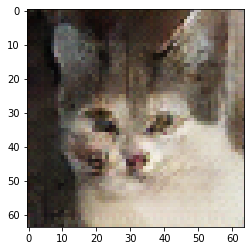

tf.Tensor([[9.9976963e-01 1.2524681e-04 1.0515373e-04]], shape=(1, 3), dtype=float32)
Step: 18, Loss: 1.8322018384933472


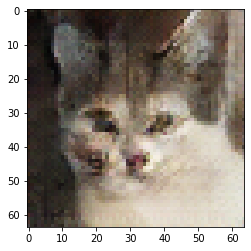

tf.Tensor([[0.8023562  0.1719521  0.02569167]], shape=(1, 3), dtype=float32)
Step: 19, Loss: 0.9084797501564026


tf.Tensor([[0.9412393  0.02918159 0.02957912]], shape=(1, 3), dtype=float32)
Step: 20, Loss: 0.7525836229324341


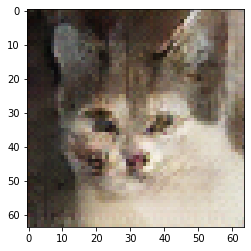

In [23]:
# Mixelt label-ök súly szerint

mixed_label = [0.8, 0.0, 0.2]

starting_noise = tf.random.truncated_normal([1, latent_dim])
result_noises, losses, preds =\
        gradient_descent_momentum(mixed_label, starting_noise, 0.005, 0.9, 21, verbose=True)

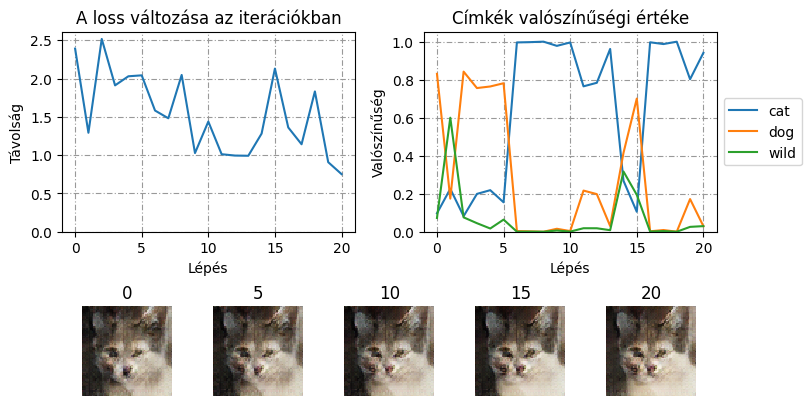

In [24]:
plot_convergence(result_noises, losses, preds, image_step=5)